# 04_train.ipynb

**Local XGBoost Model Training & Evaluation**

This notebook trains an XGBoost regressor on the preprocessed RECS features locally. It log‑transforms the target, fits with early stopping, evaluates test‑set RMSE (back‑transformed), generates feature‑importance and predicted‑vs‑actual plots, and packages the trained model for upload to S3.

In [16]:
# 04_train.ipynb
# XGBoost training notebook for KWH prediction

import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import sagemaker
import numpy as np

# 1. Load train/test splits from S3
sess = sagemaker.Session()
bucket = sess.default_bucket()

X_train = pd.read_parquet(f"s3://{bucket}/recs/train/X_train.parquet")
X_test = pd.read_parquet(f"s3://{bucket}/recs/test/X_test.parquet")
y_train = pd.read_parquet(f"s3://{bucket}/recs/train/y_train.parquet").squeeze()
y_test = pd.read_parquet(f"s3://{bucket}/recs/test/y_test.parquet").squeeze()

y_train = np.log1p(y_train)

# split train→train/valid
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Wrap in DMatrix (XGBoost format)
dtrain = xgb.DMatrix(X_tr,  label=y_tr)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# 3. Define training parameters
params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

# 4. Train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=25,
    verbose_eval=50,
)

# 5. Evaluate
preds = model.predict(dtest)
preds = np.expm1(preds)

rmse = mean_squared_error(y_test, preds, squared=False)
print(f"✅ RMSE on test set: {rmse:.2f}")

[0]	train-rmse:0.63139	valid-rmse:0.64114
[50]	train-rmse:0.11316	valid-rmse:0.16740
[100]	train-rmse:0.08378	valid-rmse:0.15369
[150]	train-rmse:0.06782	valid-rmse:0.14848
[200]	train-rmse:0.05623	valid-rmse:0.14566
[250]	train-rmse:0.04764	valid-rmse:0.14368
[300]	train-rmse:0.04121	valid-rmse:0.14237
[350]	train-rmse:0.03562	valid-rmse:0.14144
[400]	train-rmse:0.03105	valid-rmse:0.14087
[450]	train-rmse:0.02731	valid-rmse:0.14033
[499]	train-rmse:0.02416	valid-rmse:0.13992
✅ RMSE on test set: 1561.08


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


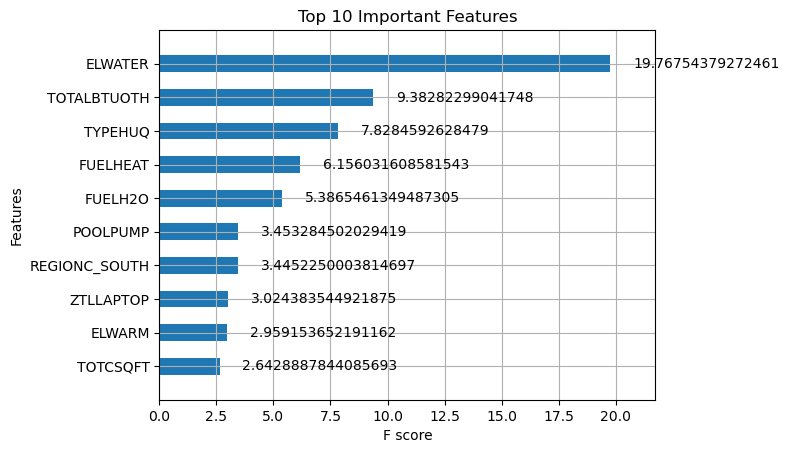

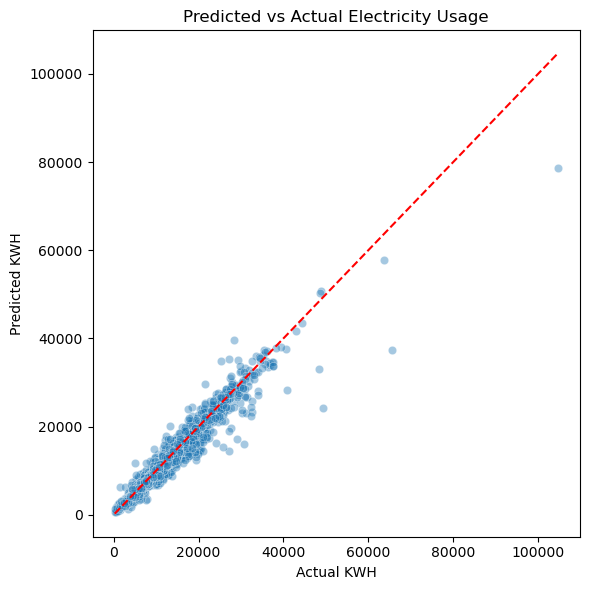

In [17]:
# 6. Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

xgb.plot_importance(model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 Important Features")
plt.show()

# 7. Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=preds, alpha=0.4)
plt.xlabel("Actual KWH")
plt.ylabel("Predicted KWH")
plt.title("Predicted vs Actual Electricity Usage")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

In [ ]:
%pip install shap

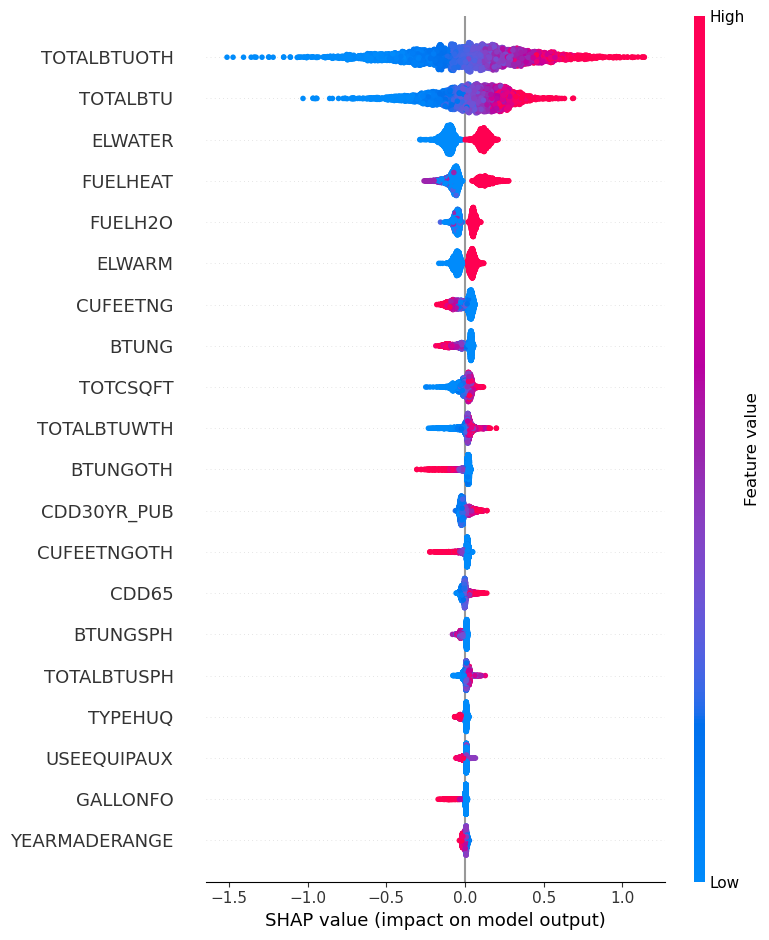

In [18]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)
shap.summary_plot(shap_values, X_test)

In [19]:
# 5. Save the trained Booster locally
model.save_model("model.bst")

# 6. Package into a tar.gz
import tarfile

with tarfile.open("model.tar.gz", "w:gz") as tar:
    tar.add("model.bst", arcname="model.bst")

# 7. Upload the tarball to S3
sess.upload_data(
    path="model.tar.gz",
    bucket=bucket,
    key_prefix="recs/output"    # writes to s3://{bucket}/recs/output/model.tar.gz
)

print(f"✅ Model packaged at s3://{bucket}/recs/output/model.tar.gz")

/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:32:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1742444421431/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


✅ Model packaged at s3://sagemaker-us-east-1-039774476556/recs/output/model.tar.gz
